# Stage 2: Advanced Embedding Models Training and Analysis
This notebook explores advanced embedding models to analyze and compare the content of the Cleantech Media and Google Patent datasets. The goal is to develop meaningful vector representations of the text data using word embeddings, sentence embeddings, and transfer learning techniques.

- Deadline 2 (Stage 2): 6 April 2025 23:59

## Data Preparation for Embeddings
At this stage, we need to ensure that our dataset is properly cleaned and preprocessed to generate high-quality embeddings.


In [118]:
#Packages
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
import unidecode
import spacy
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
PUNCTUATIONS = string.punctuation
stemmer = PorterStemmer()
from collections import Counter
from gensim.models import Word2Vec

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
# Default Style Settings
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200
#%matplotlib inline

In [90]:
!pip install gensim
!pip install spacy
!pip install unidecode

In [91]:
#load the pre-cleaned dataset
media_preprocessed_path = "../cleaned_data/media_dataset_pre-cleaned.csv"
patent_preprocessed_path = "../cleaned_data/google_patent_pre-cleaned.csv"

df_media_processed = pd.read_csv(media_preprocessed_path, header = 0)
df_patent_processed = pd.read_csv(patent_preprocessed_path, header = 0)

First, all function for the preprocessing steps are loaded:

In [92]:
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text) if isinstance(text, str) else text

def remove_dates(text):
    text = re.sub(r'\d{1,2}(st|nd|rd|th)?[-./]\d{1,2}[-./]\d{2,4}', '', text)
    pattern = re.compile(r'(\d{1,2})?(st|nd|rd|th)?[-./,]?\s?(of)?\s?([J|j]an(uary)?|[F|f]eb(ruary)?|[Mm]ar(ch)?|[Aa]pr(il)?|[Mm]ay|[Jj]un(e)?|[Jj]ul(y)?|[Aa]ug(ust)?|[Ss]ep(tember)?|[Oo]ct(ober)?|[Nn]ov(ember)?|[Dd]ec(ember)?)\s?(\d{1,2})?(st|nd|rd|th)?\s?[-./,]?\s?(\d{2,4})?')
    text = pattern.sub(r'', text)
    return text if isinstance(text, str) else text

def remove_html(text):
    clean_text = BeautifulSoup(text).get_text()
    return clean_text

def remove_tags_mentions(text):
    pattern = re.compile(r'(@\S+|#\S+)')
    return pattern.sub('', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))


def remove_whitespaces(text):
    return " ".join(text.split())

#probably not used
# def stem_words(text):
#     return ' '.join([stemmer.stem(word) for word in text.split()])

def accented_to_ascii(text):
    return unidecode.unidecode(text)

# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]

Now we apply the function to both datasets. Stopwords are retained in both the Media and Patent datasets to preserve the natural structure of the text, ensuring that important contextual relationships, technical expressions, and domain-specific phrasing remain intact. Retaining stopwords increases the dataset size and computational cost, potentially introducing noise in word embeddings. However, removing them could disrupt the meaning of technical terms in patents and the readability of media content, leading to a loss of critical contextual information.

In [117]:
# lower casing
df_patent_processed['abstract'] = df_patent_processed['abstract'].apply(lambda x: x.lower())

# Call all removals
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_emails)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_dates)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_html)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_tags_mentions)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_punctuation)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_whitespaces)
#df_patent_processed['abstract'] = df_patent_processed['abstract'].map(stem_words)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(accented_to_ascii)
df_patent_processed['tokens'] = df_patent_processed['abstract'].apply(tokenize)

df_patent_processed.head()

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,is_english,tokens
0,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,the invention discloses a distributed economic...,20231201,"['HU PENGFEI', 'LI ZIMENG']",G06Q50/06,True,"[the, invention, discloses, a, distributed, ec..."
1,CN-117147382-A,CN-202310985511-A,CN,Device for monitoring hydrogen atom crossing g...,the invention provides a device and a method f...,20231201,"['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']",G01N13/00,True,"[the, invention, provides, a, device, and, a, ..."
2,CN-113344288-B,CN-202110717505-A,CN,Cascade hydropower station group water level p...,the invention discloses a cascade hydropower s...,20231201,[],G06Q10/04,True,"[the, invention, discloses, a, cascade, hydrop..."
3,CN-117153944-A,CN-202311209193-A,CN,"Heterojunction solar cell, preparation method ...",the application provides a heterion solar cell...,20231201,"['TONG HONGBO', 'JIN YUPENG']",H01L31/074,True,"[the, application, provides, a, heterion, sola..."
4,CN-116911695-B,CN-202311167289-A,CN,Flexible resource adequacy evaluation method a...,the invention relates to a flexible resource a...,20231201,[],H02J2203/20,True,"[the, invention, relates, to, a, flexible, res..."


In [94]:
# lower casing
df_media_processed['content'] = df_media_processed['content'].apply(lambda x: x.lower())

# Call all removals
df_media_processed['content'] = df_media_processed['content'].map(remove_emails)
df_media_processed['content'] = df_media_processed['content'].map(remove_dates)
df_media_processed['content'] = df_media_processed['content'].map(remove_html)
df_media_processed['content'] = df_media_processed['content'].map(remove_tags_mentions)
df_media_processed['content'] = df_media_processed['content'].map(remove_punctuation)
df_media_processed['content'] = df_media_processed['content'].map(remove_whitespaces)
#df_media_processed['content'] = df_media_processed['content'].map(stem_words)
df_media_processed['content'] = df_media_processed['content'].map(accented_to_ascii)
df_media_processed['tokens'] = df_media_processed['content'].apply(tokenize)


df_media_processed.head()

,id,title,date,content,domain,url,tokens
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,chinese automotive startup xpeng has shown one...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,"[chinese, automotive, startup, xpeng, has, sho..."
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,sinopec has laid plans to build the largest gr...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,"[sinopec, has, laid, plans, to, build, the, la..."
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,huaneng power international has switched on a ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,"[huaneng, power, international, has, switched,..."
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,according to the iranian authorities there are...,pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,"[according, to, the, iranian, authorities, the..."
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,daily gpi infrastructure ngi all news access e...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,"[daily, gpi, infrastructure, ngi, all, news, a..."
...,...,...,...,...,...,...,...
20106,104263,US Treasury finalises 45X Advanced Manufacturi...,2024-10-24,the us department of the treasury dot has fina...,pv-tech,https://www.pv-tech.org/us-treasury-finalises-...,"[the, us, department, of, the, treasury, dot, ..."
20107,104264,EDP trials robotic construction on Spanish PV ...,2024-10-24,developer edp is piloting a robotic constructi...,pv-tech,https://www.pv-tech.org/edp-trials-robotic-con...,"[developer, edp, is, piloting, a, robotic, con..."
20108,101434,Australia has 7.8 GW of utility-scale batterie...,2024-10-24,the volume of largescale battery energy storag...,pv-magazine,https://www.pv-magazine.com/2024/10/24/austral...,"[the, volume, of, largescale, battery, energy,..."
20109,101428,Residential PV prices in Germany drop 25% with...,2024-10-24,the comparison site selfmade energy shows in a...,pv-magazine,https://www.pv-magazine.com/2024/10/24/residen...,"[the, comparison, site, selfmade, energy, show..."


In [95]:
df_media = df_media_processed.copy()
df_patent= df_patent_processed.copy()

As a last step of our cleaning we will now split the data into 20 % test and 80 % train.

In [96]:
# Split the patent dataset (80% train, 20% test)
train_patent, test_patent = train_test_split(df_patent_processed, test_size=0.2, random_state=42)
# Print the size of each split\n"
print(f"Training set: {len(train_patent)} rows")
print(f"Testing set: {len(test_patent)} rows")

Training set: 23061 rows
Testing set: 5766 rows


In [97]:
# Split the media dataset (80% train, 20% test)
train_media, test_media = train_test_split(df_media_processed, test_size=0.2, random_state=42)
# Print the size of each split\n"
print(f"Training set: {len(train_media)} rows")
print(f"Testing set: {len(test_media)} rows")

Training set: 16088 rows
Testing set: 4023 rows


## Word Embedding Training
- Train separate word embedding models on each dataset using techniques such as Word2Vec, FastText, or GloVe.
- Experiment with hyperparameters such as vector dimensions, context window size, and training epochs to optimize word embeddings evaluated using intrinsic methods such as word similarity tasks, analogy tasks and clustering and visualization.
- Use the trained embeddings to explore thematic overlaps and differences between the two datasets and identify unique insights and innovation gaps.

Baseline Model

with the tf- idf in stage 1 we already took into account the non-semantic

we use word2vec

Remember inahbility to handle unknwon or OOV words 

We stick to english, as we could not use the embedding for a new matrice

Word order is respected

is a sematntic & static, so does not take into account the order


In [115]:
word_counts_media = Counter(word for sentence in df_media['content'] for word in sentence.split())
total_tokens_media = sum(word_counts_media.values())
unique_tokens_media = len(word_counts_media)

word_counts_patent = Counter(word for sentence in df_patent['abstract'] for word in sentence.split())
total_tokens_patent = sum(word_counts_patent.values())
unique_tokens_patent = len(word_counts_patent)

print("Media:")
print(f"Total Words (Tokens): {total_tokens_media}")
print(f"Unique Words (Vocabulary Size): {unique_tokens_media}")

print("Patent:")
print(f"Total Words (Tokens): {total_tokens_patent}")
print(f"Unique Words (Vocabulary Size): {unique_tokens_patent}")

Media:
Total Words (Tokens): 14351671
Unique Words (Vocabulary Size): 191183
Patent:
Total Words (Tokens): 5310156
Unique Words (Vocabulary Size): 34717


### Baseline Model & Hyperparameter Adjustments  

Before finalizing model parameters, a **baseline Word2Vec model** will be trained using default settings. This baseline serves as a **comparison point** to assess performance improvements when adjusting hyperparameters based on dataset characteristics. Given the significant differences in dataset size and vocabulary diversity, we anticipate the need for the following optimizations:  

#### **Media Dataset (Large-scale, High-Diversity)**  
- With **14.35M tokens** and **191k unique words**, this dataset has high lexical diversity and requires an efficient training approach.  
- **CBOW (`sg=0`)** is expected to perform well due to its efficiency in handling large datasets.  
- **Window Size:** To be adjusted to `7` to capture broader semantic relationships.  
- **Feature Size (Vector Dimensionality):**  `300` will be tested to best represent the large vocabulary.  
- **Min Word Count:** A threshold of `10` will help filter infrequent words while maintaining training efficiency.  

#### **Patent Dataset (Moderate-scale, Domain-Specific)**  
- With **5.31M tokens** and a more compact vocabulary of **34.7k unique words**, this dataset contains specialized terminology.  
- **Skip-gram (`sg=1`)** is expected to yield better results by enhancing rare technical term representations.  
- **Window Size:** To be adjusted to `7` to capture broader semantic relationships. 
- **Feature Size:** A range of `200` will be evaluated, considering the domain-specific nature of the vocabulary.  
- **Min Word Count:** Expected to be **lowered to `3`** to retain rare but meaningful terms.  

### Next Steps & Expected Outcomes  
The baseline model will provide a performance benchmark. By comparing its results with the optimized models, we can assess improvements in word representations and downstream task performance. The final choice of hyperparameters will balance **computational efficiency** with **semantic accuracy**, tailored to the specific characteristics of each dataset.


In [123]:
#Train Benchmark Model fro Media

# Set values for various parameters from example
feature_size = 100  # The dimensionality of the word vectors.
window_context = 5  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 5  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_media_standard = Word2Vec(sentences=df_media['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [124]:
#Train Optimized  Model for Media

# Set values for various parameters
feature_size = 300  # Most popular choive
window_context = 7  # Context window size
min_word_count = 10  # Minimum word count
w2vmodel_media_optimized = Word2Vec(sentences=df_media['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

Now let's compare the similarity similar words in the different models (calculated by cosine similarity).

In [127]:
w2vmodel_media_standard.wv.most_similar('energy', topn=5)

[('electricity', 0.6811129450798035),
 ('power', 0.6075395345687866),
 ('energies', 0.5114042162895203),
 ('energyket', 0.48642271757125854),
 ('resource', 0.4612565338611603)]

In [130]:
w2vmodel_media_optimized.wv.most_similar('energy', topn=5)

[('power', 0.5102176666259766),
 ('electricity', 0.5056303143501282),
 ('energies', 0.45400673151016235),
 ('energyket', 0.4318004250526428),
 ('intermittent', 0.3634028434753418)]

**Key Insights**

- The **baseline model** shows stronger associations with **"electricity"** and **"power"**, reflecting conventional energy concepts.  
- The **optimized model** distributes similarity more evenly, introducing **"intermittent"**, which may indicate improved context awareness.  
- Lower similarity scores in the optimized model suggest a broader semantic representation rather than overfitting to dominant terms.  

## Word Embedding Visualization Comparison  

To analyze the impact of hyperparameter tuning, we applied **t-SNE** to visualize word embeddings from both the **baseline** and **optimized** Word2Vec models. The same **word sampling range** (`index_to_key[200:350]`) and **t-SNE settings** (`n_components=2, perplexity=5, n_iter=5000, random_state=0`) were used to ensure comparability. 

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


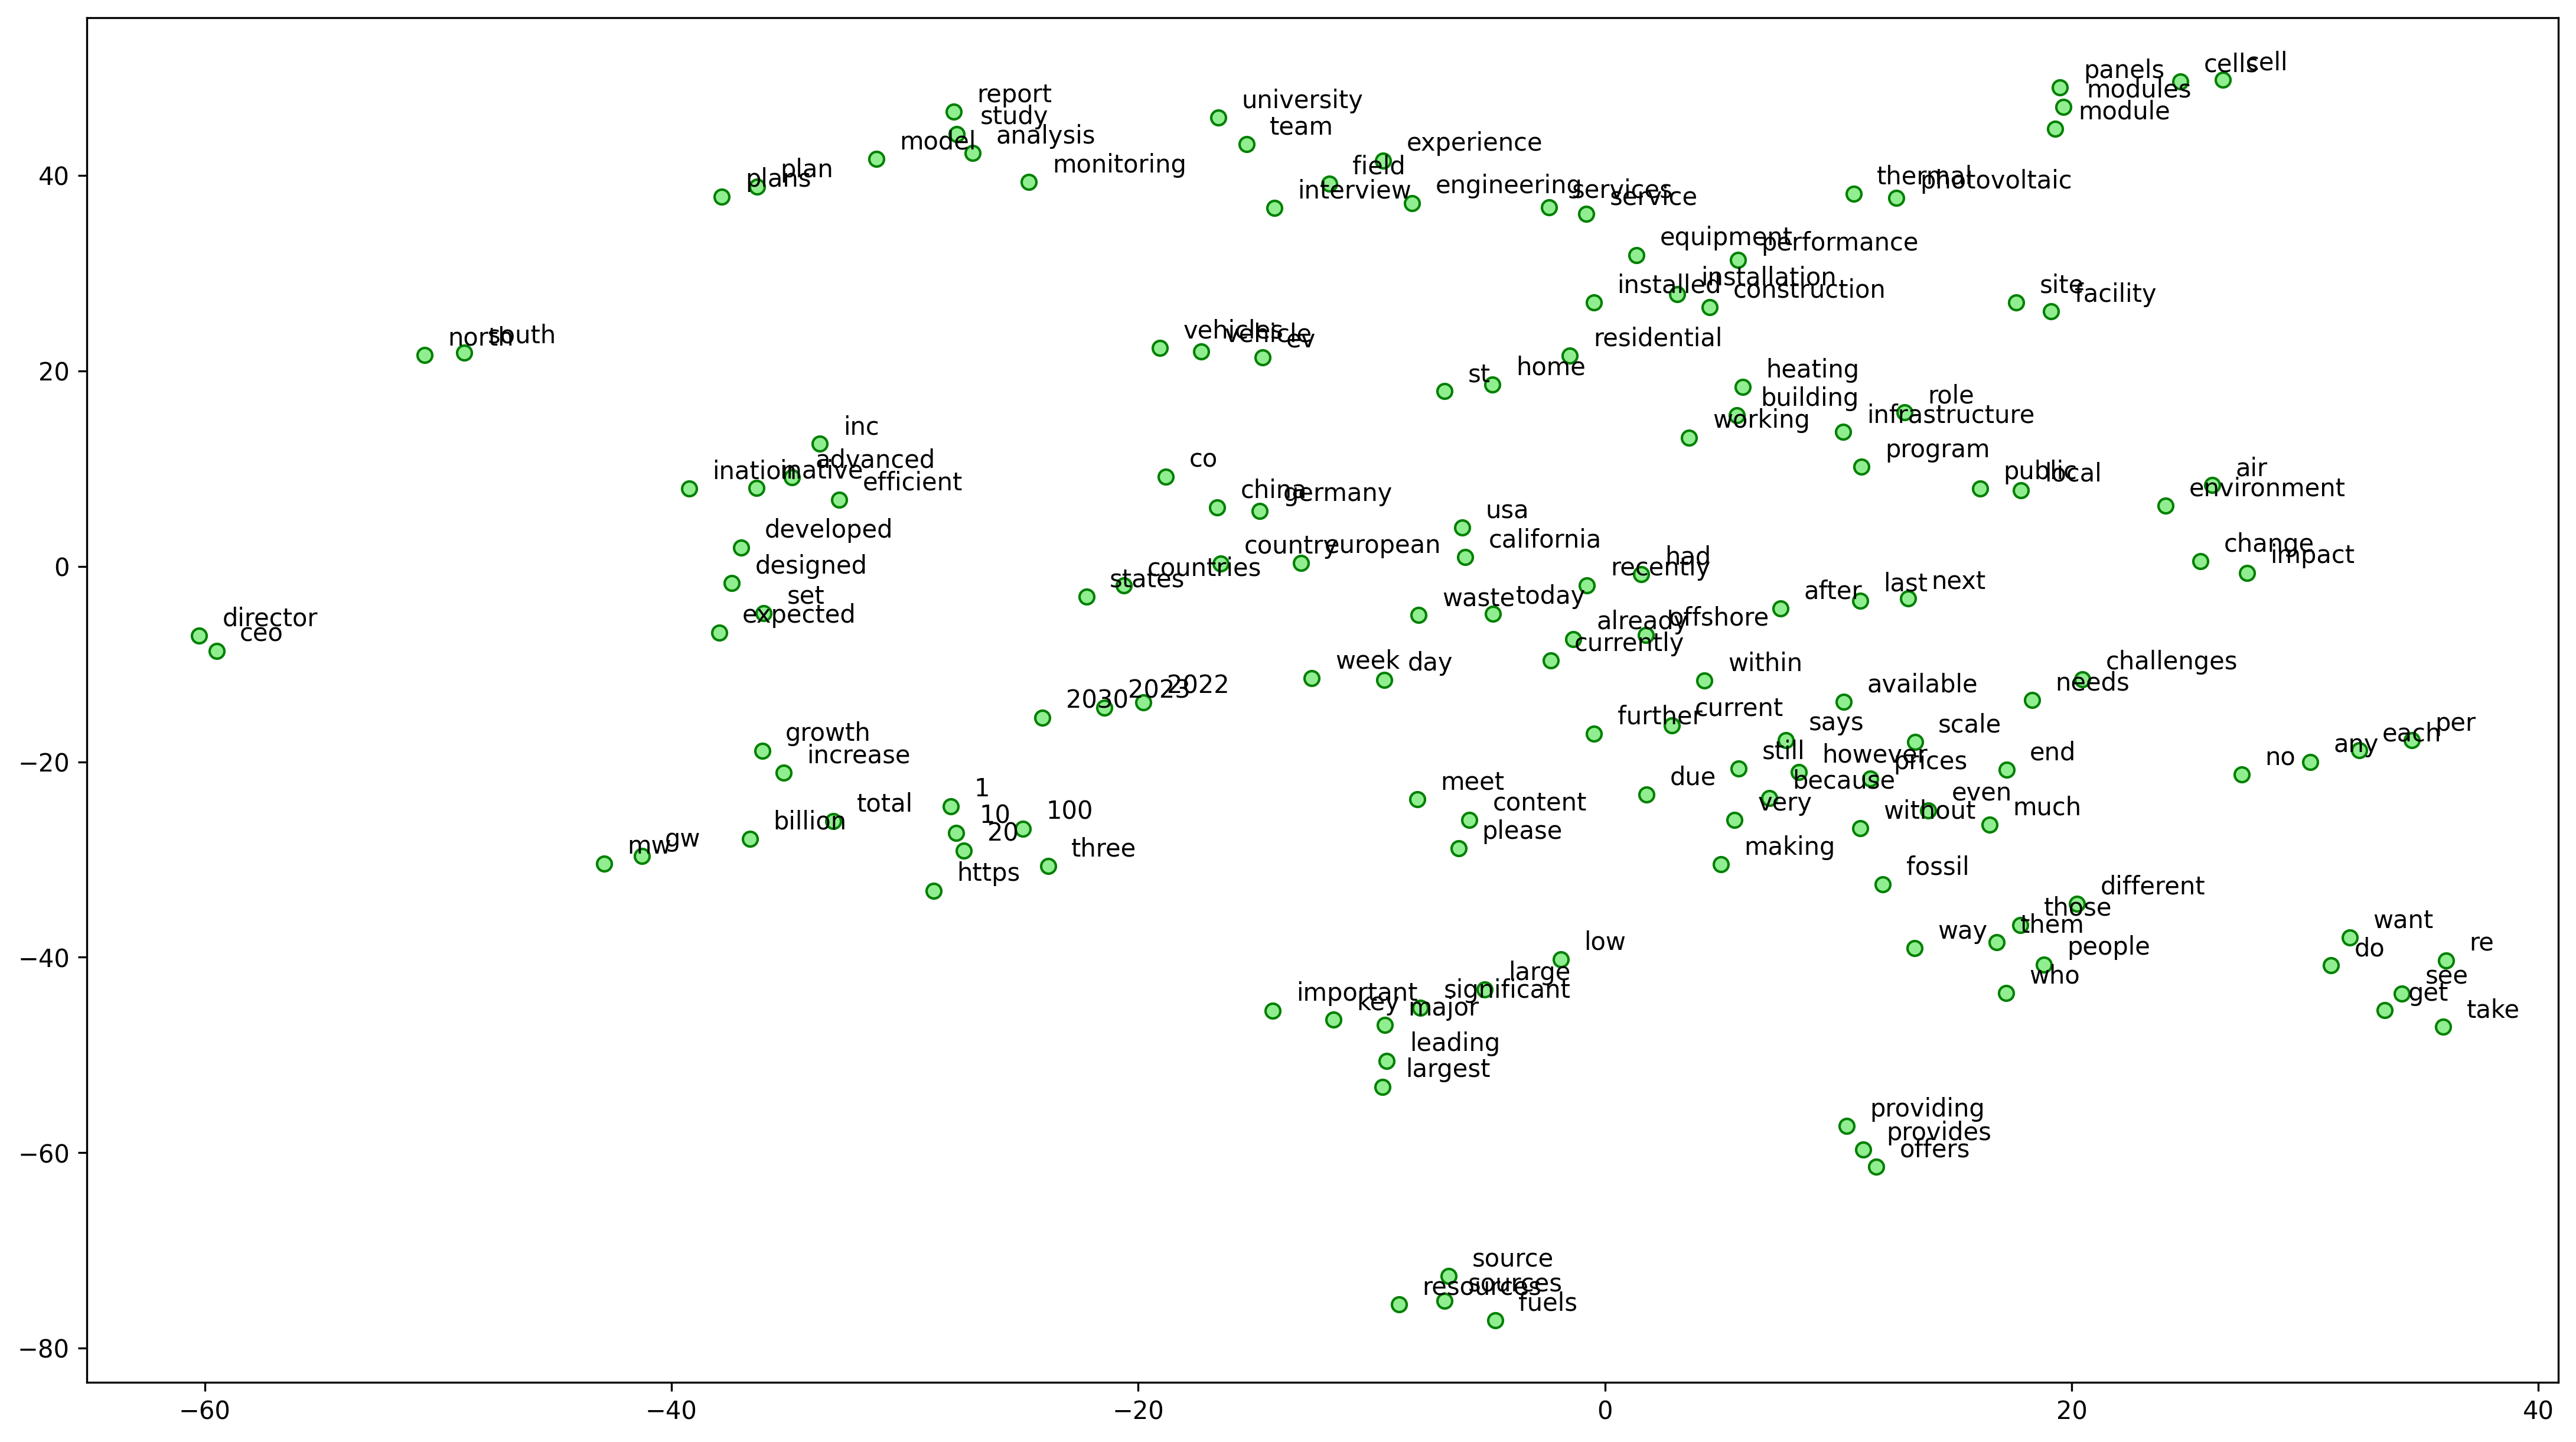

In [132]:
from sklearn.manifold import TSNE

words = w2vmodel_media_standard.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_media_standard.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


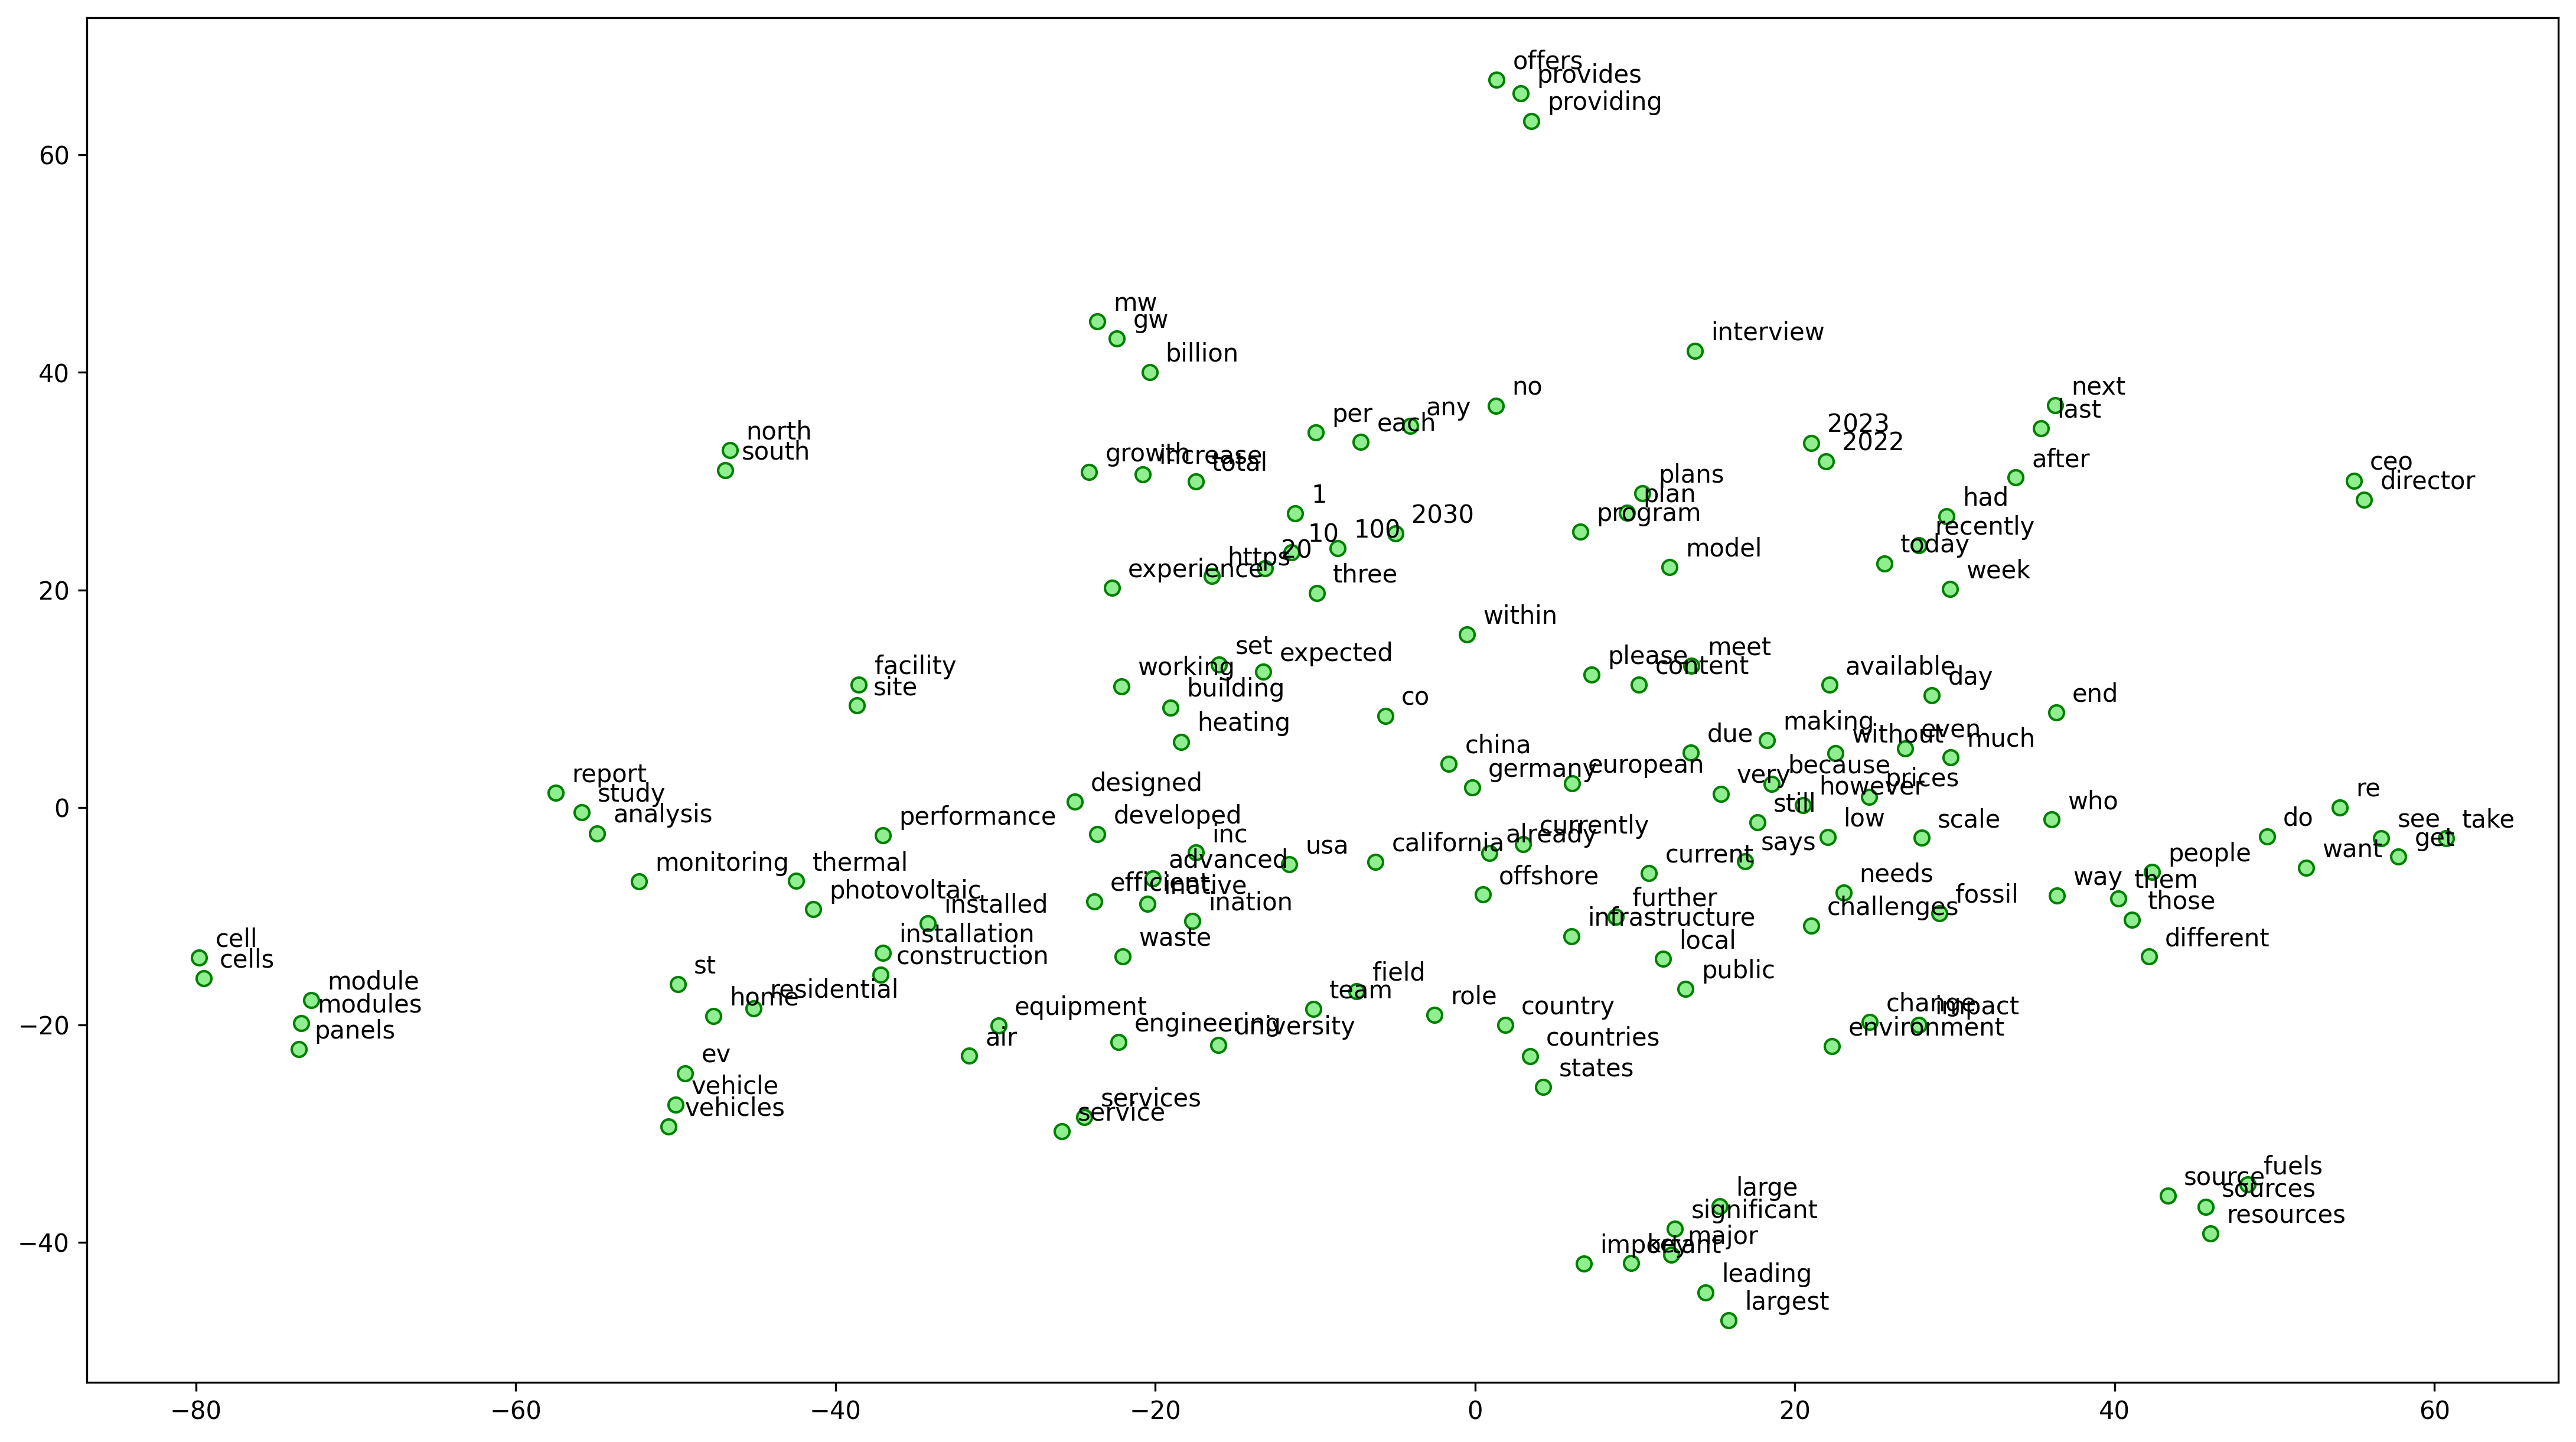

In [133]:
from sklearn.manifold import TSNE

words = w2vmodel_media_optimized.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_media_optimized.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

**Key Observations**  
- The overall structure of both models is similar, indicating that core word relationships remain stable.  
- Some **word placements differ**, reflecting changes in how the models understand word similarity.  
- The optimized model may show a **clearer semantic structure**, but further evaluation is needed to confirm improvements in downstream tasks.  

**Conclusion**  
By keeping the sampling and visualization settings identical, we highlight the impact of **hyperparameter tuning** on word embeddings. The optimized model nor the standard provides a better visual performance,  additional testing is needed to quantify improvements beyond visualization.  

As we finished the media dataset let's now train two Word2Vec on the patent dataset

In [125]:
#Train Benchmark Model for Patent

# Set values for various parameters from example
feature_size = 100  # The dimensionality of the word vectors.
window_context = 5  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 5  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_patent_standard = Word2Vec(sentences=df_patent['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [126]:
#Train Benchmark Model for Patent

# Set values for various parameters from example
feature_size = 200  # The dimensionality of the word vectors.
window_context = 7  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 3  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_patent_optimized = Word2Vec(sentences=df_patent['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 1)

Now we do the same and compare the similarity similar words in the different models 

In [135]:
w2vmodel_patent_standard.wv.most_similar('energy', topn=5)

[('power', 0.6145719289779663),
 ('electricity', 0.5494726896286011),
 ('heat', 0.5201087594032288),
 ('heating', 0.4771978259086609),
 ('conversion', 0.45995739102363586)]

In [136]:
w2vmodel_patent_optimized.wv.most_similar('energy', topn=5)

[('lowquality', 0.6879629492759705),
 ('storable', 0.6810980439186096),
 ('bicycles', 0.6699875593185425),
 ('peltier', 0.6666039824485779),
 ('energyelectric', 0.6631563305854797)]

**Key Insights**

- **Patent Baseline Model:** Similar words to **"energy"** include **"power"**, **"electricity"**, and **"heat"**, reflecting conventional energy concepts.  
- **Patent Optimized Model:** Returns **"lowquality"**, **"storable"**, and **"peltier"**, indicating a shift toward niche or less expected associations.  
- **Comparison with Media Dataset:**  
  - The **Media optimized model** retains clearer energy-related terms.  
  - The **Patent optimized model** diverges more, suggesting stronger domain adaptation but potentially noisier relationships.  


The optimized **Patent model** produced unexpected similar words for **"energy"**, likely due to the following factors:  

- **Feature Size (`200`) May Be Too Small:** A higher dimensionality (**300-400**) could better capture technical term relationships.  
- **Skip-gram (`sg=1`) Overfitting to Rare Words:** May prioritize low-frequency terms, leading to noisier associations.  
- **Window Size (`7`) Too Large:** Capturing broader context may have linked distant, less relevant terms. A **smaller window (3-5)** could improve focus.  
- **Domain-Specific Language Variability:** Patent terminology varies, and **"energy"** may appear in unexpected contexts (e.g., **"peltier"**, **"bicycles"**) due to specific technical applications.  



Next step is visualizing the two models as before.

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


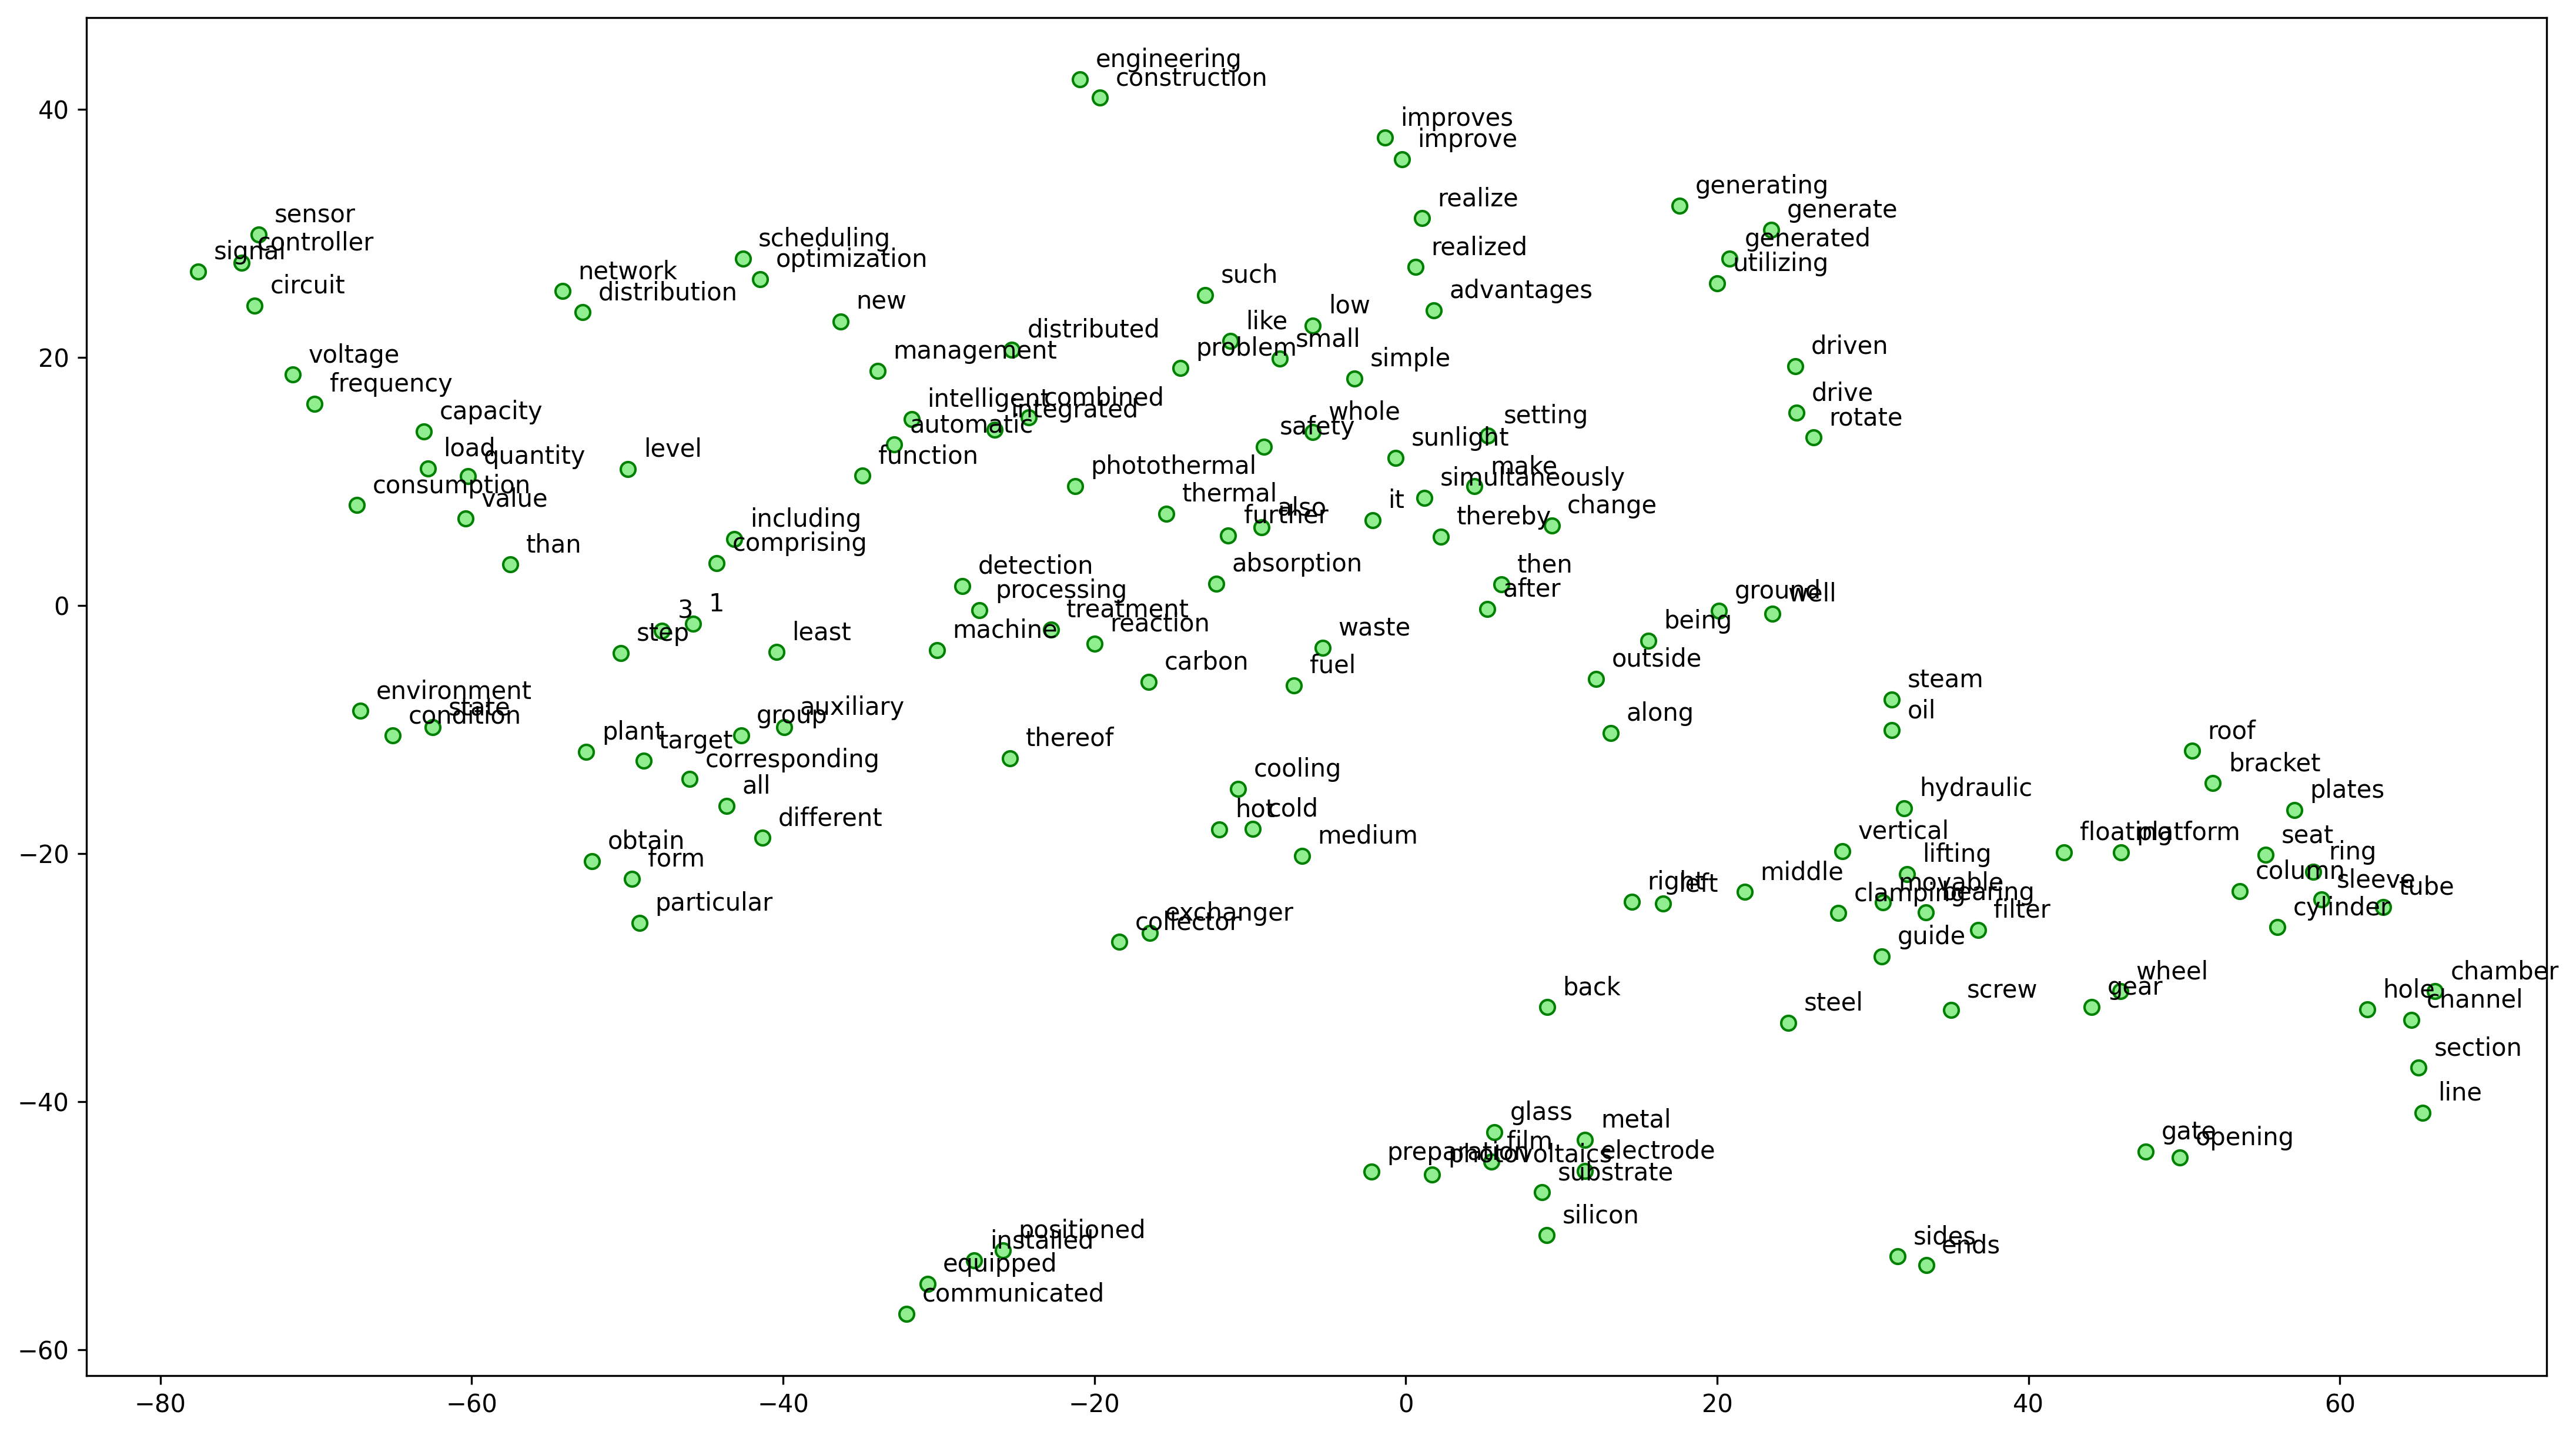

In [138]:
from sklearn.manifold import TSNE

words = w2vmodel_patent_standard.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_patent_standard.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


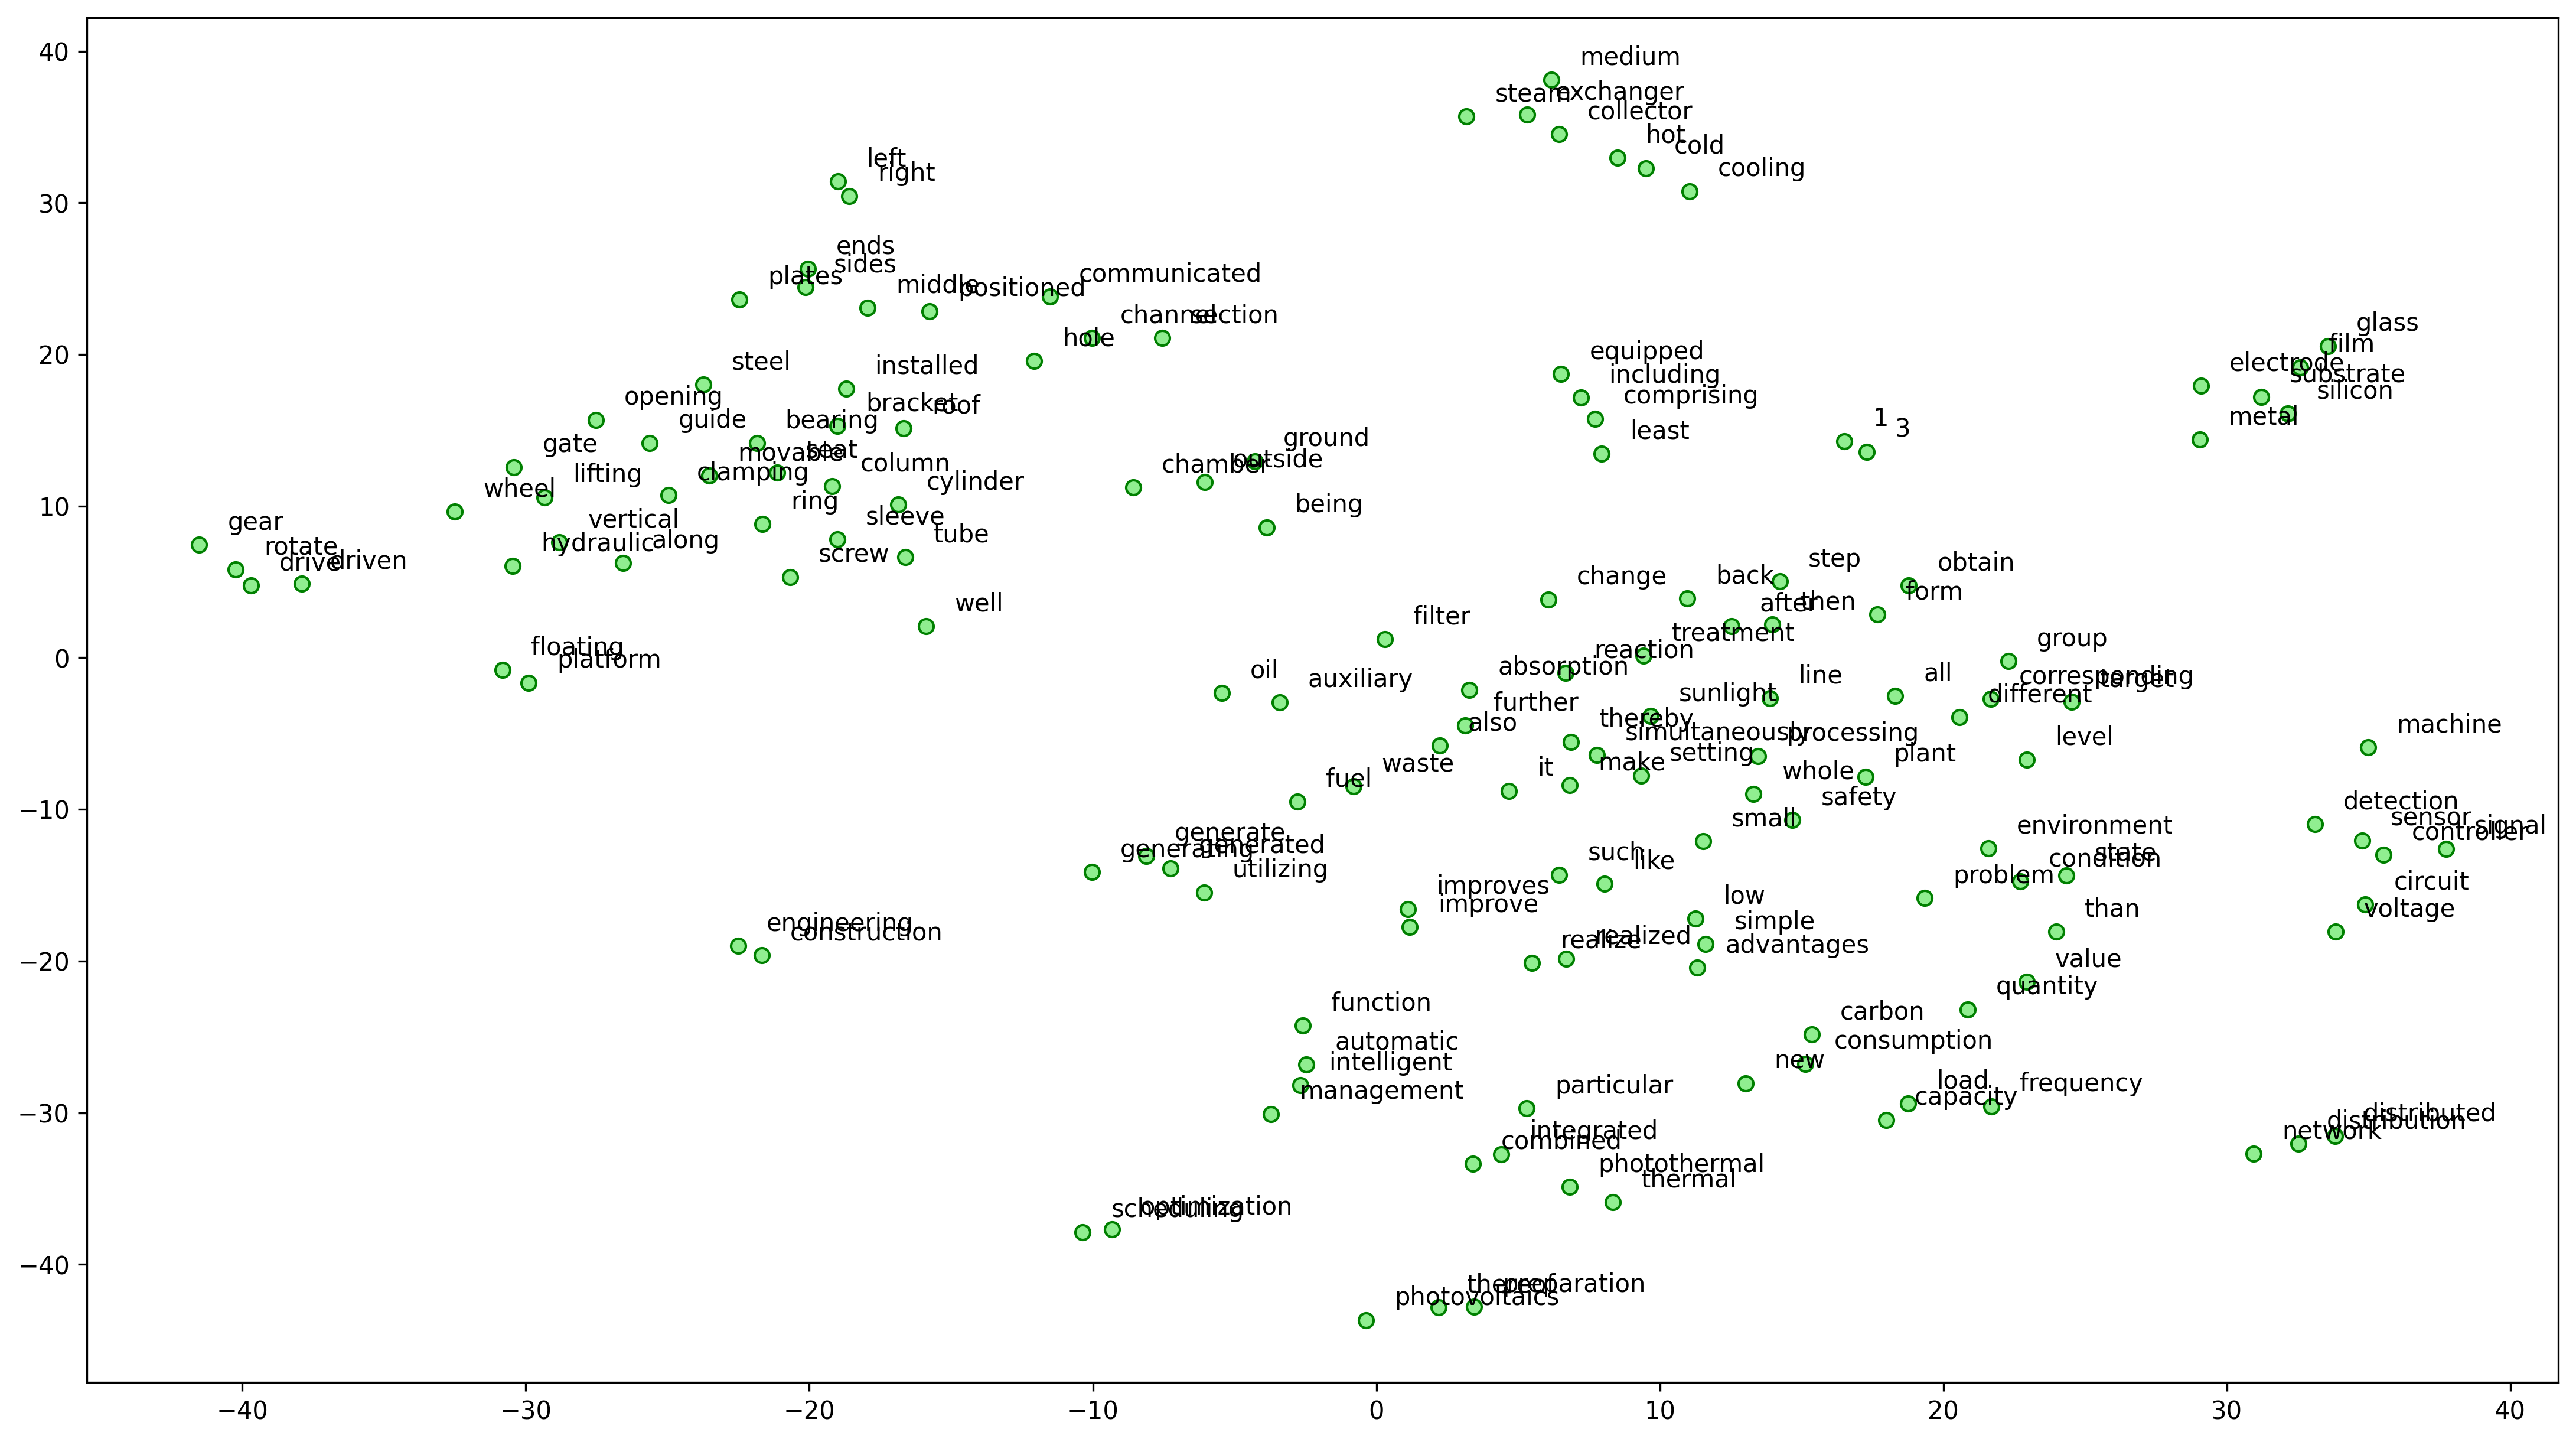

In [137]:
from sklearn.manifold import TSNE

words = w2vmodel_patent_optimized.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_patent_optimized.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

**Key Insights from Patent Dataset Visualization**
- **Baseline Model (Left):**  
  - Words appear **more loosely scattered**, with **some structure** but less distinct clusters.  

- **Optimized Model (Right):**  
  - Clusters are **more defined**, indicating better **semantic separation**.  
  - Some unrelated words may still appear close, likely due to **overfitting to rare terms (Skip-gram)**.  

## Sentence Embedding Training
- Train separate sentence embedding models on each dataset using methods such as averaging word vectors, Doc2Vec, or BERT embeddings.
- Experiment with hyperparameters such as vector dimensions, context window size, learning rate, batch size and training epochs to optimize sentence embeddings evaluated using intrinsic methods such as sentence similarity tasks and clustering and visualization.
- Use the trained embeddings to explore thematic overlaps and differences between the two datasets and identify unique insights and innovation gaps.

## Transfer Learning with Advanced Open-Source Models
- Implement transfer learning by fine-tuning pre-trained open-source models such as RoBERTa, XLNet, Longformer, FLAN-T5, and BART on the text data. Evaluate the model performance using intrinsic measures (e.g., word similarity, clustering quality) before and after fine-tuning. Analyze and quantify the insights gained from the fine-tuned model regarding emerging trends and innovation gaps in cleantech.
- Compare the performance of transfer learning with the in-house embeddings. This comparison could be done through evaluating the effectiveness of the embeddings in domain-specific tasks like topic classification.